# Newtonian Tidal Disruption of Compact Binaries

We expect certain types of LIGO signals to have electromagnetic (EM) counterparts &mdash; bright, transient explosions visible to optical, radio, or high-energy telescopes at or sometime near the time of the gravitational wave signal. For example, around 5-10% of neutron star binary mergers (either NS-NS or NS-BH) will probably produce short-duration $\gamma$-ray bursts, and around 20-50% of them will have optical "afterglows" that last for a few days after the merger ([Metzger & Berger, 2012](http://iopscience.iop.org/article/10.1088/0004-637X/746/1/48/meta)). During certain NS-BH mergers, the neutron star can be destroyed by tidal forces as it spirals toward the black hole, forming an accretion disk that powers the EM counterpart.

This diagram illustrates the situation:

![](binary_diagram.png)

In this Jupyter notebook, we'll use Newtonian gravity to investigate the basic physics of tidal disruption when a neutron star of radius $R_{\rm NS}$ and mass $m_{\rm NS}$ spirals into a black hole of mass $m_{\rm BH}$, whose spin angular momentum $\mathbf{S}_{\rm BH}$ is aligned with the orbital angular momentum. In particular, we'll try to understand when and how tidal disruption results in an accretion disk, and how this relates to the black hole's rate of spin. For a more detailed look at accretion-driven EM counterparts, see e.g. [Foucart, 2012](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.86.124007).

---

First, we'll need the Python modules `numpy` and `matplotlib`:

In [1]:
# Imports.
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

Next, we'll need to define some physical constants (particularly $G$ and $c$) and set the neutron star mass to a typical value of $m_{\rm NS} = 1.4\,M_{\odot}$. We'll also want to choose a range of neutron star radii, which will act as a proxy for its equation of state:

In [2]:
# Physical constants.
G = 6.67408e-11  # Newton's constant in m^3 / kg / s
MSun = 1.989e30  # Solar mass in kg
c = 299792458.   # Speed of light in m/s
m_NS = 1.4*MSun  # NS mass in kg
R_NS = np.array([11e3, 12e3, 13e3])  # Neutron star radii to try, in meters

Now, it makes sense to define a couple of functions to do our heavy lifting. The first of these should locate the radius of the innermost stable circular orbit (ISCO) given a black hole mass ($m_{\rm BH}$) and spin angular momentum (represented by the dimensionless number $\chi_{\rm BH} = G\vert\mathbf{S}_{\rm BH}\vert/Gm_{\rm BH}^2$). According to GR, this happens when the binary is separated by a distance $a_{\rm ISCO}$ given by

\begin{equation*}
\frac{c^2a_{\rm ISCO}}{Gm_1} = 3 + Z_2 - {\rm sgn}(\chi) \sqrt{(3-Z_1)(3+Z_1+2Z_2)}
\end{equation*}

where the functions $Z_1$ and $Z_2$ are given by

\begin{align*}
Z_1 &= 1 + (1 - \chi^2)^{1/3} \left[ (1+\chi^2)^{1/3} + (1-\chi^2)^{1/3} \right] \\
Z_2 &= \sqrt{3\chi^2 + Z_1^2}.
\end{align*}

In [3]:
# Define a function that locates ISCO given the BH mass and spin.
def aISCO(m, chi):
    Z1 = 1 + (1 - chi**2)**(1./3) * ((1 + chi)**(1./3) + (1 - chi)**(1./3))
    Z2 = np.sqrt(3*chi**2 + Z1**2)
    f = 3 + Z2 - np.sign(chi) * np.sqrt((3 - Z1) * (3 + Z1 + 2*Z2))
    return f * G * m / c**2

Note: when you use this function, remember it is **vitally important** that $-1 < \chi_{\rm BH} < 1$, where a negative number means the black hole spins opposite to the orbit. If you step outside of these limits, you will rip a hole through space and time. This would be very bad. **Do not rip a hole through space and time.**

The second function will locate the orbital separation at which tidal diruption occurs, $a_{\rm td}$. This is roughly identified as the point in the inspiral where tidal stresses acting on the neutron star overcome its own self-gravity, ripping this giant ultra-compact space atom to smitherines. To identify this point, note that tidal stresses arise from a force differential across the neutron star. Along the axis separating both objects, when they are a distance $a$ apart, this is given by

\begin{equation*}
f_{\rm tide} = -GM\left[ \frac{1}{(a - R_{\rm NS})^2} - \frac{1}{(a + R_{\rm NS})^2} \right]
\end{equation*}

where $M = m_{\rm BH} + m_{\rm NS}$ is the total mass of the system. The neutron star self-gravity is of course

\begin{equation*}
f_{\rm grav} = \frac{G\mu}{R_{\rm NS}^2}
\end{equation*}

where $\mu = m_{\rm BH}m_{\rm NS}/M$ is the reduced mass. Thus, we can compute an array of force gradients at several test values of $a$, compare them to the self-gravity, then find a zero-crossing:

In [4]:
# Define a function for locating the tidal disruption point.
def disrupt(m1, R, m2=1.4*MSun, tol=1e-4):
    M = m1 + m2  # total mass in kg
    M0 = G * M / c**2  # total mass in m
    mu = m1 * m2 / M  # reduced mass in kg
    a_test = np.linspace(M0, 24*M0, int(1/tol))
    fgrav = G * mu / R**2  # NS self-gravity
    ftide = -G * M * (1/(a_test - R)**2 - 1/(a_test + R)**2)  # tidal force due to BH
    ftot = fgrav + ftide  # total force
    return a_test[ np.abs(ftot).argmin() ]

Now we're ready for the main body of the code, which simply makes repeated calls to our two functions `aISCO` and `disrupt` inside of a loop:

In [5]:
# Set array of primary masses to try.
masses = np.linspace(1.4*MSun, 18*m_NS, 1000)
atd = [ np.array([]) for i in xrange(len(R_NS)) ]

# Find the disruption point for each primary mass and several different spins.
for i in xrange(len(R_NS)):
    for m_BH in masses:
        atd[i] = np.append( atd[i], disrupt(m_BH, R_NS[i]) )

---
To visualize the relationship between tidal disruption and mass ratio, we can make a couple of plots. First, we want to know how the ratio between $a_{\rm td}$ and $a_{\rm ISCO}$ scales with the mass ratio $q = m_{\rm BH}/m_{\rm NS}$. Put simply, if tidal disruption occurs outside of ISCO then an accretion disk will form; otherwise, the neutron star plunges in without forming a disk (and thus, without producing an EM counterpart).

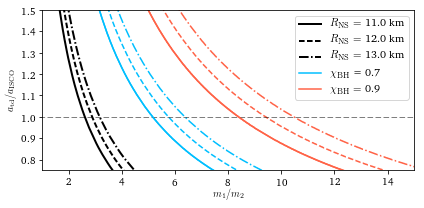

In [6]:
# Plot the ratio of a_td/a_ISCO as a function of direct mass ratio.
fig = plt.figure( figsize=(6, 3) )
ax = fig.add_subplot(1, 1, 1)
ls = ['solid', 'dashed', 'dashdot']
for i in xrange(len(R_NS)):
    ax.plot(masses/m_NS, atd[i]/aISCO(masses, 0), 'k', linestyle=ls[i], linewidth=2.,
        label=r'$R_{\rm NS} =$ %.1f km' % (R_NS[i]/1e3))
    ax.plot(masses/m_NS, atd[i]/aISCO(masses, 0.7), 'DeepSkyBlue', linestyle=ls[i])
    ax.plot(masses/m_NS, atd[i]/aISCO(masses, 0.9), 'Tomato', linestyle=ls[i])
ax.plot([0, 25], [1, 1], 'k--', linewidth=0.5)
ax.plot(masses/m_NS, atd[0]/aISCO(masses, 0.7), 'DeepSkyBlue', label=r'$\chi_{\rm BH}$ = 0.7')
ax.plot(masses/m_NS, atd[0]/aISCO(masses, 0.9), 'Tomato', label=r'$\chi_{\rm BH} =$ 0.9')
ax.set_xlim([1, 15])
ax.set_xlabel('$m_1/m_2$')
ax.set_ylim([0.75, 1.5])
ax.set_ylabel(r'$a_{\rm td}/a_{\rm ISCO}$')
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
ax.legend(loc=1, fontsize=11, fancybox=True)
fig.tight_layout()
plt.savefig('disruption_point.pdf')

From this plot, we can convince ourselves that destroying a neutron star becomes easier as the neutron star gets less dense, which might not be surprising &mdash; but it also becomes easier as the black hole spins faster! Would it blow your mind if I told you that this happens because, when a black hole spins, it *drags space and time along with it*, causing even more extreme gravity? When you pick a fight with a raging monster the size of a city spinning faster than a kitchen blender, **you're going to lose that fight.**

Finally, our second plot visualizes where the boundary between EM-bright and EM-dark lies as a function of neutron star radius and black hole mass and spin:

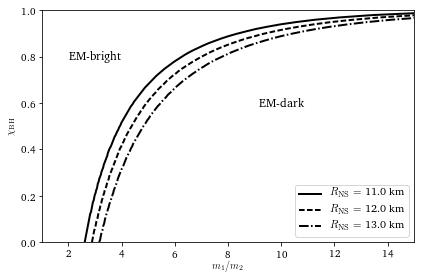

In [7]:
# For each NS radius, plot the boundary where a_td = a_ISCO as a function of BH mass and spin.
chi_BH = np.linspace(0, 0.999, 100)  # range of BH spins
q = [ np.array([]) for i in xrange(len(R_NS)) ]
for x in chi_BH:
    ISCO = aISCO(masses, x)
    for i in xrange(len(R_NS)):
        q[i] = np.append( q[i], masses[np.abs(atd[i]/ISCO - 1).argmin()] / m_NS )

fig = plt.figure( figsize=(6, 4) )
ax = fig.add_subplot(1, 1, 1)
for i in xrange(len(R_NS)):
    ax.plot(q[i], chi_BH, 'k', linestyle=ls[i], linewidth=2.,
            label=r'$R_{\rm NS} =$ %.1f km' % (R_NS[i]/1e3))
ax.set_xlim([1, 15])
ax.set_xlabel('$m_1/m_2$')
ax.set_ylim([0, 1])
ax.set_ylabel(r'$\chi_{\rm BH}$')
ax.annotate('EM-dark', xy=(10, 0.6), xycoords='data', size=12, ha="center", va="center")
ax.annotate('EM-bright', xy=(3, 0.8), xycoords='data', size=12, ha="center", va="center")
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
ax.legend(loc=4, fontsize=11, fancybox=True)
fig.tight_layout()
plt.savefig('qchi_diagram.pdf')